<a href="https://colab.research.google.com/github/paulo-batista/LABDATA-FIA/blob/main/Artificial-Intelligence/ml_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

In [3]:
pasta_raiz = '/content/drive/MyDrive/datasets/datasets/ifood'

In [4]:
df_orders = pd.read_csv(f'{pasta_raiz}/df_orders.csv', parse_dates=['order_timestamp_local'])
df_orders.head(3)

,order_id,order_number,order_timestamp_local,order_shift,last_status_date_local,order_total,credit,paid_amount,delivery_type,scheduled,...,distance_merchant_customer,promo_is_promotion,normal_items_quantity,promo_items_quantity,order_lag_at_login,order_lead_at_login,order_date_local,valid_order,session_id,customer_id
0,630e2af0-b456-4b3a-b964-4d66ce5cc5df,1290139943,2019-12-11 13:22:06.497000+00:00,weekday lunch,2019-12-11T15:22:39.156Z,28.90,14.0,24.9,DELIVERY,False,...,2722.603906,0.0,2.0,0.0,2.0,1.0,2019-12-11T00:00:00.000Z,1,ccbcf9e2-3728-4458-a813-4031ae22e4bd,48b6d81407646ca61163f064a426ce38ac08bed2ce84f0...
1,66f8163d-f081-4fbd-adb8-cfbbff9213f7,1141271215,2019-11-06 17:57:17.967000+00:00,weekday dinner,2019-11-06T18:18:48.680Z,56.35,7.9,50.4,DELIVERY,False,...,1108.823183,1.0,0.0,1.0,7.0,1.0,2019-11-06T00:00:00.000Z,1,d9e94d88-ca88-4997-ad4c-62b9c0a35c1b,b3f74186880f5f9a79e0865ad8beab47e22b785b8b3bc0...
2,e8c55557-81d4-4159-bd2b-c144e5fbabe3,694742752,2019-06-11 20:42:32.058000+00:00,weekday dinner,2019-06-11T22:42:54.005Z,53.80,4.0,49.8,DELIVERY,False,...,1642.258522,0.0,2.0,0.0,5.0,1.0,2019-06-11T00:00:00.000Z,1,035b33cd-6ddf-4ee2-a887-7ba490bb9700,c4f8999d4cb83cac8134b2051ffc611d5d660c049c3744...


In [5]:
df = (
    df_orders
    .assign(order_date = df_orders['order_timestamp_local'].dt.date)
    .groupby('order_date')
    .agg(receita = ('order_total', 'sum'))
    .reset_index()
    .sort_values('order_date')
    .filter(['order_date', 'receita'])
)
df.head()

,order_date,receita
0,2019-06-01,209061.01
1,2019-06-02,213995.65
2,2019-06-03,108973.96
3,2019-06-04,106973.23
4,2019-06-05,122957.05


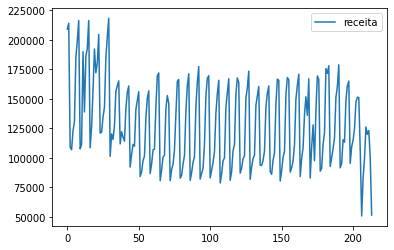

In [6]:
df.plot()

In [7]:
df['order_date'] = pd.to_datetime(df['order_date'])

df_train = df.query('order_date < "2019-12-01"')
df_test = df.query('order_date >= "2019-12-01"')

print(df_train.shape)
print(df_test.shape)

(183, 2)
(31, 2)


In [8]:
df_train =(df_train
    .assign(mes = df_train['order_date'].dt.month)
    .assign(dia = df_train['order_date'].dt.day)
    .assign(weekday = df_train['order_date'].dt.dayofweek)
    .assign(dayofyear = df_train['order_date'].dt.dayofyear)
)

df_test =(df_test
    .assign(mes = df_test['order_date'].dt.month)
    .assign(dia = df_test['order_date'].dt.day)
    .assign(weekday = df_test['order_date'].dt.dayofweek)
    .assign(dayofyear = df_test['order_date'].dt.dayofyear)
)

In [12]:
df_train.shape

(183, 6)

In [13]:
df_test.shape

(31, 6)

In [14]:
df['receita'][:4].shift(1)

0          NaN
1    209061.01
2    213995.65
3    108973.96
Name: receita, dtype: float64

In [15]:
df['receita'][:4].shift(2)

0          NaN
1          NaN
2    209061.01
3    213995.65
Name: receita, dtype: float64

In [16]:
df_train =(df_train
        .assign(receita_atual = df_train['receita'].shift(1))
        .assign(receita_anterior = df_train['receita'].shift(2))
        .assign(diff_receitas = lambda df: (df['receita_atual'] - df['receita_anterior']))
)
df_train.head(5)

,order_date,receita,mes,dia,weekday,dayofyear,receita_atual,receita_anterior,diff_receitas
0,2019-06-01,209061.01,6,1,5,152,NaN,NaN,NaN
1,2019-06-02,213995.65,6,2,6,153,209061.01,NaN,NaN
2,2019-06-03,108973.96,6,3,0,154,213995.65,209061.01,4934.64
3,2019-06-04,106973.23,6,4,1,155,108973.96,213995.65,-105021.69
4,2019-06-05,122957.05,6,5,2,156,106973.23,108973.96,-2000.73


In [17]:
df_test =(df_test
        .assign(receita_atual = df_test['receita'].shift(1))
        .assign(receita_anterior = df_test['receita'].shift(2))
        .assign(diff_receitas = lambda df : (df['receita_atual'] - df['receita_anterior']))
)
df_test.head(5)

,order_date,receita,mes,dia,weekday,dayofyear,receita_atual,receita_anterior,diff_receitas
183,2019-12-01,178085.12,12,1,6,335,NaN,NaN,NaN
184,2019-12-02,92833.10,12,2,0,336,178085.12,NaN,NaN
185,2019-12-03,99995.42,12,3,1,337,92833.10,178085.12,-85252.02
186,2019-12-04,107698.24,12,4,2,338,99995.42,92833.10,7162.32
187,2019-12-05,117057.18,12,5,3,339,107698.24,99995.42,7702.82


In [18]:
df_train['receita_atual'][:9]

0          NaN
1    209061.01
2    213995.65
3    108973.96
4    106973.23
5    122957.05
6    130615.30
7    185314.25
8    199144.33
Name: receita_atual, dtype: float64

In [19]:
df_train['receita_atual'][:9].rolling(3).mean()

0              NaN
1              NaN
2              NaN
3    177343.540000
4    143314.280000
5    112968.080000
6    120181.860000
7    146295.533333
8    171691.293333
Name: receita_atual, dtype: float64

In [20]:
df_train = (df_train
    .assign(media_movel = df_train['receita_atual'].rolling(3).mean())
)

In [21]:
# Adicione seu codigo aqui para criar as variáveis solicitadas no exercício para o df_test:
df_test = (df_test
    .assign(media_movel = df_test['receita_atual'].rolling(3).mean())
)

##Modelagem 

In [22]:
features = ['mes', 'dia', 'weekday', 'dayofyear', 'receita_atual', 'receita_anterior', 'diff_receitas', 'media_movel']
target   = 'receita'

In [23]:
df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

print('X_train -',X_train.shape,' y_train -', y_train.shape)
print('X_test -', X_test.shape,'y_test -',y_test.shape)


X_train - (180, 8)  y_train - (180,)
X_test - (28, 8) y_test - (28,)


##Regressão Linear

In [24]:
!pip install feature_engine

     |████████████████████████████████| 205 kB 26.8 MB/s 
     |████████████████████████████████| 9.8 MB 44.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline

lr_model = Pipeline(steps=[
    ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler())),
    ('linear_regression', LinearRegression())
])

lr_model.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler())),
                ('linear_regression', LinearRegression())])

##Criando Função que retorna todas as Métricas

In [30]:
# importando as métricas
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

# definindo métricas auxiliares
def adjusted_r2(y_esperado, y_previsto, X_treino):
  r2 = r2_score(y_esperado, y_previsto)
  N = len(y_esperado)
  p = X_treino.shape[1]

  r2_ajustado = (1 - ((1 - r2) * (N - 1)) / (N - p - 1))
  return r2_ajustado

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))

def log_results(modelo_objeto, nome_modelo, X_train, X_test, y_train, y_test):
    # crie aqui o código da sua função
    y_previsto = modelo_objeto.predict(X_train)
    y_esperado = y_train.copy()
    r2_train = r2_score(y_esperado, y_previsto)
    adjustedr2_train = adjusted_r2(y_esperado, y_previsto, X_train)
    mse_train = mean_squared_error(y_esperado, y_previsto)
    rmse_train = np.sqrt(mse_train)
    rmsle_train = np.sqrt(mean_squared_log_error(y_esperado, y_previsto))
    mae_train = mean_absolute_error(y_esperado, y_previsto)
    medae_train = median_absolute_error(y_esperado, y_previsto)
    mape_train = mape(y_esperado, y_previsto)
    treino = 'treino'
    teste = 'teste'

    y_previsto = modelo_objeto.predict(X_test)
    y_esperado = y_test.copy()
    r2_test = r2_score(y_esperado, y_previsto)
    adjustedr2_test = adjusted_r2(y_esperado, y_previsto, X_test)
    mse_test = mean_squared_error(y_esperado, y_previsto)
    rmse_test = np.sqrt(mse_test)
    rmsle_test = np.sqrt(mean_squared_log_error(y_esperado, y_previsto))
    mae_test = mean_absolute_error(y_esperado, y_previsto)
    medae_test = median_absolute_error(y_esperado, y_previsto)
    mape_test = mape(y_esperado, y_previsto)

    return pd.DataFrame(data={
    'modelo' : [nome_modelo, nome_modelo], 
    'modo': ['treino', 'teste'],
    'R2' : [r2_train, r2_test],
    'R2 ajustado' : [adjustedr2_train, adjustedr2_test],
    'MSE' : [mse_train, mse_test],
    'RMSE' : [rmse_train, rmse_test],
    'RMSLE' : [rmsle_train, rmsle_test],
    'MAE' : [mae_train, mae_test],
    'MEDAE' : [medae_train, medae_test],
    'MAPE' : [mape_train, mape_test]
  })

In [31]:
lr_results = log_results(lr_model, 'Regressão Linear', X_train, X_test, y_train, y_test)

##Ridge Regression

In [32]:
from sklearn.linear_model import Ridge

ridge_model = Pipeline(steps=[('scaling', SklearnTransformerWrapper(transformer=StandardScaler(), variables=features)),
                              ('model', Ridge())])

# continue o código abaixo
ridge_model.fit(X_train, y_train)

ridge_results = log_results(ridge_model, 'Ridge', X_train, X_test, y_train, y_test)
ridge_results

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,Ridge,treino,0.841957,0.834563,1.969900e+08,14035.311375,0.102559,10672.764852,8595.277860,0.081940
1,Ridge,teste,0.655312,0.510180,3.396867e+08,18430.592704,0.195752,15391.855336,12434.615462,0.154088


##Decision Tree

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=30, max_depth=3)

# continue o código abaixo
tree_model.fit(X_train, y_train)

tree_results = log_results(tree_model, 'Decision Tree', X_train, X_test, y_train, y_test)
tree_results

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,Decision Tree,treino,0.923725,0.920157,9.507078e+07,9750.424492,0.073733,6746.007212,4908.518958,0.053235
1,Decision Tree,teste,0.602498,0.435129,3.917338e+08,19792.265011,0.210369,14953.630908,11020.422754,0.161242


##Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=30, max_depth=3)

# continue o código abaixo
rf_model.fit(X_train, y_train)

rf_results = log_results(rf_model, 'Random Forest', X_train, X_test, y_train, y_test)
rf_results

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,Random Forest,treino,0.937190,0.934252,7.828801e+07,8848.050998,0.067646,6261.550404,5111.061725,0.049868
1,Random Forest,teste,0.649702,0.502208,3.452153e+08,18579.969520,0.202509,13758.379365,10473.344013,0.151276


##LGBM

In [35]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(random_state=30)


# continue o código abaixo
lgbm_model.fit(X_train, y_train)

lgbm_results = log_results(lgbm_model, 'LGBM', X_train, X_test, y_train, y_test)
lgbm_results

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,LGBM,treino,0.972437,0.971148,3.435530e+07,5861.339264,0.041866,3840.388186,2335.820206,0.029630
1,LGBM,teste,0.675813,0.539313,3.194828e+08,17874.082353,0.201195,12159.993930,6421.430539,0.140102


##XGBoost

In [36]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=30)

# continue o código abaixo
xgb_model.fit(X_train, y_train)

xgb_results = log_results(xgb_model, 'XGB', X_train, X_test, y_train, y_test)
xgb_results

[23:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,XGB,treino,0.988030,0.987470,1.492003e+07,3862.645202,0.029643,2791.044634,2037.927344,0.021965
1,XGB,teste,0.517286,0.314038,4.757097e+08,21810.770186,0.231611,15371.529408,9879.521719,0.174200


##CatBoost

In [37]:
!pip install catboost==0.25.1

     |████████████████████████████████| 67.3 MB 12 kB/s 


In [38]:
from catboost import CatBoostRegressor

In [39]:
cat_model = CatBoostRegressor(random_state=30)

# continue o código abaixo
cat_model.fit(X_train, y_train)

cat_results = log_results(cat_model, 'cat', X_train, X_test, y_train, y_test)
cat_results

Learning rate set to 0.028763
0:	learn: 34562.4926932	total: 53.2ms	remaining: 53.2s
1:	learn: 34037.0082301	total: 62.1ms	remaining: 31s
2:	learn: 33377.3096763	total: 63.3ms	remaining: 21s
3:	learn: 32787.4715584	total: 70.4ms	remaining: 17.5s
4:	learn: 32148.8641297	total: 71.6ms	remaining: 14.2s
5:	learn: 31591.4462022	total: 76.5ms	remaining: 12.7s
6:	learn: 31130.6405119	total: 80.2ms	remaining: 11.4s
7:	learn: 30534.1115904	total: 84ms	remaining: 10.4s
8:	learn: 29976.7288115	total: 88.4ms	remaining: 9.74s
9:	learn: 29398.5790885	total: 90.9ms	remaining: 9s
10:	learn: 28862.3723273	total: 98.7ms	remaining: 8.87s
11:	learn: 28355.1041543	total: 101ms	remaining: 8.28s
12:	learn: 27828.2913495	total: 105ms	remaining: 7.95s
13:	learn: 27315.5620659	total: 109ms	remaining: 7.66s
14:	learn: 26824.7410509	total: 113ms	remaining: 7.39s
15:	learn: 26368.7271883	total: 116ms	remaining: 7.16s
16:	learn: 25911.4417675	total: 120ms	remaining: 6.95s
17:	learn: 25492.3172232	total: 124ms	remai

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,cat,treino,0.999161,0.999122,1.045180e+06,1022.340307,0.008317,813.358367,672.576628,0.006579
1,cat,teste,0.427845,0.186938,5.638524e+08,23745.576676,0.247428,17455.239741,13120.248447,0.195485


##Juntando todos os resultados

In [40]:
model_results = pd.concat([lr_results, ridge_results, tree_results, rf_results, lgbm_results, xgb_results, cat_results ])
model_results

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,Regressão Linear,treino,0.851830,0.844898,1.846833e+08,13589.823475,0.102354,10438.198114,8183.734656,0.081407
1,Regressão Linear,teste,0.545792,0.354547,4.476170e+08,21156.961622,0.221724,18787.508466,16495.304482,0.176210
0,Ridge,treino,0.841957,0.834563,1.969900e+08,14035.311375,0.102559,10672.764852,8595.277860,0.081940
1,Ridge,teste,0.655312,0.510180,3.396867e+08,18430.592704,0.195752,15391.855336,12434.615462,0.154088
0,Decision Tree,treino,0.923725,0.920157,9.507078e+07,9750.424492,0.073733,6746.007212,4908.518958,0.053235
1,Decision Tree,teste,0.602498,0.435129,3.917338e+08,19792.265011,0.210369,14953.630908,11020.422754,0.161242
0,Random Forest,treino,0.937190,0.934252,7.828801e+07,8848.050998,0.067646,6261.550404,5111.061725,0.049868
1,Random Forest,teste,0.649702,0.502208,3.452153e+08,18579.969520,0.202509,13758.379365,10473.344013,0.151276
0,LGBM,treino,0.972437,0.971148,3.435530e+07,5861.339264,0.041866,3840.388186,2335.820206,0.029630
1,LGBM,teste,0.675813,0.539313,3.194828e+08,17874.082353,0.201195,12159.993930,6421.430539,0.140102


###Qual o modelo que apresentou o melhor R2 ajustado na base de treino?
 CatBoost apresentou melhor resultado - 0.999122

In [41]:
model_results.sort_values(by='R2', ascending=False)

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,cat,treino,0.999161,0.999122,1.045180e+06,1022.340307,0.008317,813.358367,672.576628,0.006579
0,XGB,treino,0.988030,0.987470,1.492003e+07,3862.645202,0.029643,2791.044634,2037.927344,0.021965
0,LGBM,treino,0.972437,0.971148,3.435530e+07,5861.339264,0.041866,3840.388186,2335.820206,0.029630
0,Random Forest,treino,0.937190,0.934252,7.828801e+07,8848.050998,0.067646,6261.550404,5111.061725,0.049868
0,Decision Tree,treino,0.923725,0.920157,9.507078e+07,9750.424492,0.073733,6746.007212,4908.518958,0.053235
0,Regressão Linear,treino,0.851830,0.844898,1.846833e+08,13589.823475,0.102354,10438.198114,8183.734656,0.081407
0,Ridge,treino,0.841957,0.834563,1.969900e+08,14035.311375,0.102559,10672.764852,8595.277860,0.081940
1,LGBM,teste,0.675813,0.539313,3.194828e+08,17874.082353,0.201195,12159.993930,6421.430539,0.140102
1,Ridge,teste,0.655312,0.510180,3.396867e+08,18430.592704,0.195752,15391.855336,12434.615462,0.154088
1,Random Forest,teste,0.649702,0.502208,3.452153e+08,18579.969520,0.202509,13758.379365,10473.344013,0.151276


## Qual o modelo que apresentou o melhor R2 ajustado na base de teste?
LGBM - 0.539313

##Grid Search do Melhor Modelo

In [42]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [-2, 0, 1],
    'learning_rate': [0.01, 0.15, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.8, 0.4, 0.2],
    'subsample': [0.8, 0.6, 1.0],
}

grid_search = GridSearchCV(lgbm_model, parameters, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=30), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.4, 0.2],
                         'learning_rate': [0.01, 0.15, 0.2],
                         'max_depth': [-2, 0, 1],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.6, 1.0]},
             scoring='r2')

In [43]:
grid_search.best_params_
best_model = grid_search.best_estimator_

log_results(best_model, 'Best model', X_train, X_test, y_train, y_test)

,modelo,modo,R2,R2 ajustado,MSE,RMSE,RMSLE,MAE,MEDAE,MAPE
0,Best model,treino,0.922685,0.919068,9.636756e+07,9816.698020,0.068138,6572.242501,4381.502929,0.049929
1,Best model,teste,0.651998,0.505470,3.429527e+08,18518.981816,0.215706,12234.010170,7911.620380,0.147695


##Feature Importance

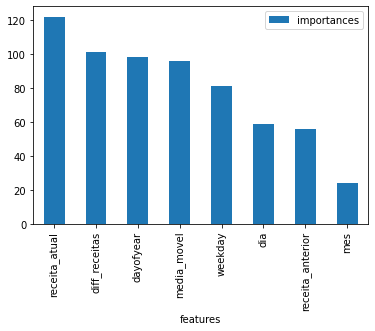

In [44]:
X_test.columns.to_list()
feature_importances_df = pd.DataFrame({
    'features': X_test.columns.to_list(),
    'importances': lgbm_model.feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df.plot(y='importances',x='features', kind='bar')

##Shap Values

In [45]:
!pip install shap

     |████████████████████████████████| 564 kB 20.3 MB/s 


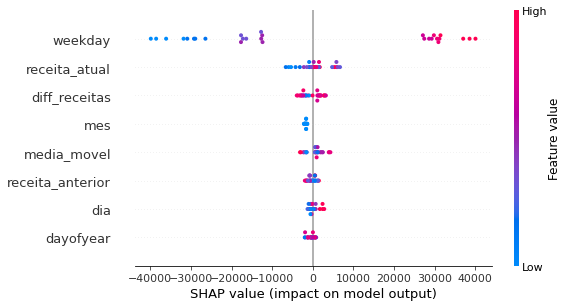

In [46]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)